# Imports

In [1]:
import torch
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('daily_prices/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek
1252,2023-10-05,173.789993,175.449997,172.679993,174.910004,174.910004,48527900,3
1253,2023-10-06,173.800003,177.990005,173.179993,177.490005,177.490005,57224100,4
1254,2023-10-09,176.809998,179.050003,175.800003,178.990005,178.990005,42390800,0
1255,2023-10-10,178.100006,179.720001,177.949997,178.389999,178.389999,43698000,1
1256,2023-10-11,178.199997,179.850006,177.600006,179.800003,179.800003,47477300,2


In [3]:
# Extract the time and value columns
time_series = np.array(range(len(df['Date'])))  # Replace with your time column name
values = df['Close']                            # Replace with your value column name

# Test dataset

In [4]:
from dataset import SP_500
from torch.utils.data import DataLoader

dataset = SP_500('daily_prices')
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=0)

In [5]:
example = next(iter(dataloader))[0]
example

tensor([[0.3926, 0.7888, 0.7735, 0.8173, 0.5108],
        [0.3453, 0.7917, 0.7753, 0.8163, 0.5061],
        [0.3736, 0.7849, 0.7665, 0.8105, 0.4665],
        ...,
        [0.3207, 0.7911, 0.7750, 0.8152, 0.5026],
        [0.4051, 0.7879, 0.7701, 0.8126, 0.5006],
        [0.3683, 0.7884, 0.7703, 0.8139, 0.4970]], dtype=torch.float64)

# Stats Models Seasonal Decompose

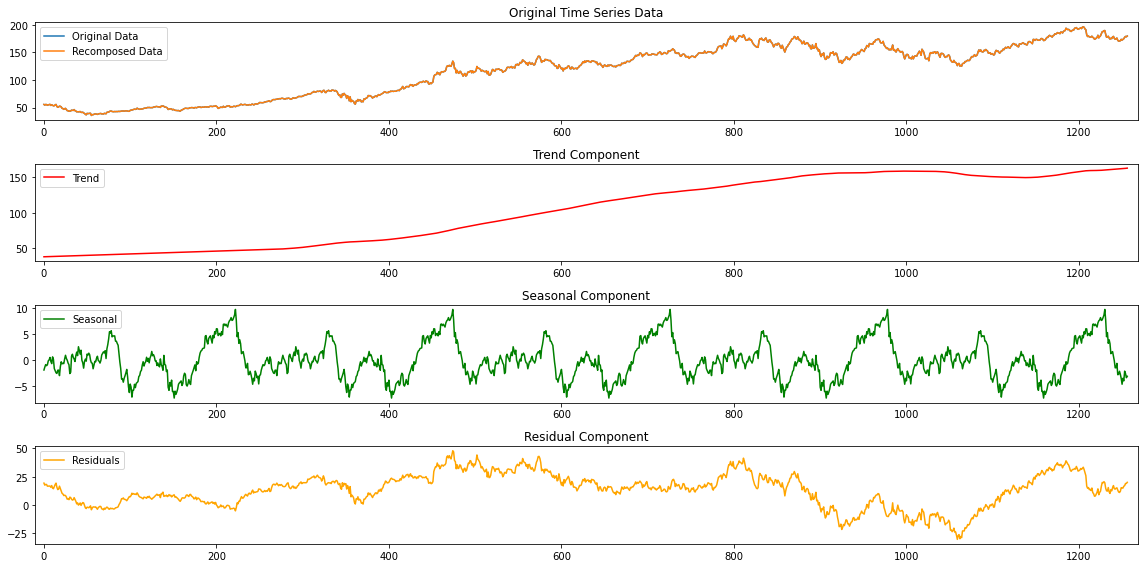

In [7]:
# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(values, model='additive', period=252, extrapolate_trend=25, two_sided=False)

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series, values, label='Original Data')
plt.plot(time_series, result.resid+result.trend+result.seasonal, label='Recomposed Data')
plt.xlim(-10,1268)
plt.legend()
plt.title('Original Time Series Data')

plt.subplot(4, 1, 2)
plt.plot(time_series, result.trend, label='Trend', color='red')
plt.xlim(-10,1268)
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(time_series, result.seasonal, label='Seasonal', color='green')
plt.xlim(-10,1268)
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(time_series, result.resid, label='Residuals', color='orange')
plt.xlim(-10,1268)
plt.legend()
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Plotting Seasonal Compnents (Extrapolating)

In [44]:
seasonal_forecast = result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean()
seasonal_forecast

0     -4.581125
1     -3.748407
2     -3.445695
3     -3.058875
4     -2.713721
         ...   
247   -1.953549
248   -2.221897
249   -2.459955
250   -2.692216
251   -2.808813
Name: seasonal, Length: 252, dtype: float64

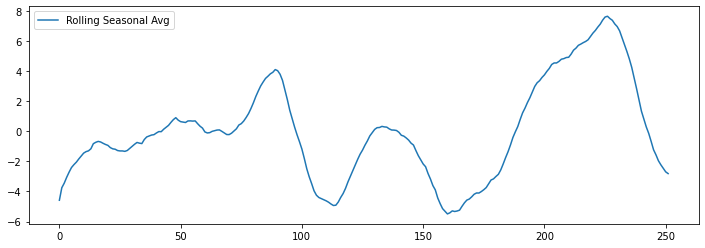

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean(), label='Rolling Seasonal Avg')
plt.legend(loc='best')
plt.show()

# Plotting Trend Component (Extrapolating)

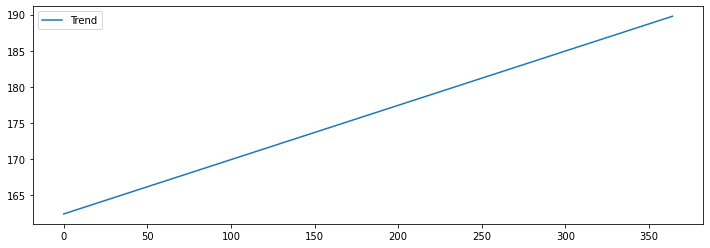

In [8]:
model = LinearRegression()
model.fit(time_series[-50:].reshape(-1, 1), result.trend[-50:])

trendline = model.intercept_ + model.coef_ * range(time_series[-1], time_series[-1]+365)

plt.figure(figsize=(12, 4))
plt.plot(trendline, label='Trend')
plt.legend(loc='best')
plt.show()

# Day of week effect

In [25]:
df.groupby('DayOfWeek')['Close'].rolling(window=3, min_periods=1).mean().reset_index()

,DayOfWeek,level_1,Close
0,0,1,54.340000
1,0,6,54.751249
2,0,11,54.187500
3,0,16,52.873333
4,0,21,50.666667
...,...,...,...
1252,4,1233,182.083334
1253,4,1238,180.883332
1254,4,1243,175.993327
1255,4,1248,173.669998


# Create trend and seasonal forecasts

In [ ]:
# create seasonal forecast component based on moving avg
forecast['seasonal_forecast'] = result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean()

# create trend forecast component based on OLS
model = LinearRegression()
model.fit(np.array(data.index[-50:]).reshape(-1, 1), result.trend[-50:])
forecast['trend_forecast'] = model.intercept_ + model.coef_ * range(data.index[-1], data.index[-1]+252)